<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/EX_BS2_project12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 버전 확인

In [2]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.5 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=f78f90e93508faa1891d66cd750df24b8bbb399c33b31f90acbeeee763c5b99a
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [3]:
from importlib_metadata import version
import nltk
import tensorflow
import summa

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

3.7
2.8.2
1.2.0


## Step 1. 데이터 수집하기


In [4]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
77437,J&K cops ask Pak High Commission to claim LeT ...,Jammu and Kashmir Police have approached the P...
5066,Baring may buy CCD Founder's Mindtree stake fo...,Baring Private Equity Asia has reportedly emer...
2116,Pandya-Rahul drama spoiled India's Test series...,Former India captain Sunil Gavaskar has said s...
25667,Companies that collect user data have no right...,Talking about the ownership rights over users'...
9869,Fitch keeps India's rating unchanged for 12th ...,Fitch Ratings on Thursday retained India's sov...
13479,Lust is replacing love: Karan Johar on loss of...,"Karan Johar, on being asked how showcasing rom..."
58269,The Big Bang Theory's Kaley Cuoco gets engaged...,'The Big Bang Theory' actress Kaley Cuoco got ...
75021,Adani Group accused of illegally diverting Ã¢Â...,Indian customs intelligence has accused Adani ...
6471,Dhoni must play domestic cricket for India sel...,World Cup-winning former Indian cricketer Mohi...
95074,"Arunachal borders Tibet, not China: CM on Dala...",Slamming China for its objection to Dalai Lama...


- headlines와 text 두가지 열로 구성되어 있음
- 추상적 요약을 할 때는 headlines를 미리 요약되어 있는 문장으로 간주해도 됨
- 추출적 요약을 할 때는 text만 이용

## Step 2. 데이터 전처리하기 (추상적 요약)


- 중복치 확인

In [7]:
print('전체 headline 데이터', len(data['headlines']))
print('유니크한 headline 데이터: ', (data['headlines'].nunique()))
print('전체 text 데이터', len(data['text']))
print('유니크한 text데이터', data['text'].nunique())

전체 headline 데이터 98401
유니크한 headline 데이터:  98280
전체 text 데이터 98401
유니크한 text데이터 98360


- 중복치 제거

headlines는 요약된 내용이므로 중복이 될 수도 있지만 text자체가 중복이 되면 안되기 때문에 text에서 중복치들을 지워준다

In [8]:
data.drop_duplicates(subset = ['text'], inplace = True)
print(len(data['text']))

98360


- Null값 확인

null값이 존재하지 않는것을 확인

In [9]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- 텍스트 정규화와 불용어 제거


In [10]:
# 정규화 사전 준비

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
from collections import Counter
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z0-9_]", " ", sentence) # 영어 외 문자(특수문자 등) 공백으로 변환
    # 단어 내에 같은 문자들이 3개 이상 연속해서 반복되면 삭제하고 최대 2개까지만 반복되도록 만들어줌( ex. iiit -> iit )
    b=[]
    for i in sentence.split():
      a = list(i)
      char_cnt = 0
      for j in a:
        if a.count(j) >= 3:
          a.remove(j)
      word_a = ''.join(a)
      b.append(word_a)
    sentence = ' '.join(b)

          
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1) 
        # sentence를 공백으로 나눈 단어들 중에서 불용어에 포함 되어있지 않은 단어만을 사이에 공백을 두고 합친다( 단어의 길이가 1보다 클 때)

    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


- 전처리 전, 후 확인

임의로 작성한 문장


In [13]:
temp_text = 'Everything I bought was great, infact I ordered iiiiit twice and the third ordered 123 was<br />for my mother and father. '
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered iit twice third ordered 123 wasfor mother father
summary: great way to start the day


- data['text'] 부분 전처리 진행

In [14]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iit pg program machine learning artficial intlligence sr ystems ngineer infosys almost years work xprience program upgrad 360 dgree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 200 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bokmyshow ubereats cult fit', 'new zealand dfeated india wickets fourth odi hamilton thursday win first match five match odi series india lost iternational match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also c

In [15]:
clean_headlines=[]
# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
  clean_headlines.append(preprocess_sentence(s, False))

#전처리 후 출력
print('Headlines 전처리 후 결과: ', clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with 90 salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india 12 match wining streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


전처리 진행 후 각 데이터에서 빈 값이 생겼는지 확인

In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


추가적인 null값이 생기지 않은 것을 알 수 있음

- train, test 데이터 나누기

먼저 text, headlines데이터들의 길이 분포를 시각화 해봄

텍스트 길이 최대:  60
텍스트 길이 최소:  1
텍스트 길이 평균:  36.420994306628714
헤드라인 길이 최대:  16
헤드라인 길이 최소:  1
헤드라인 길이 평균:  9.569591297275315


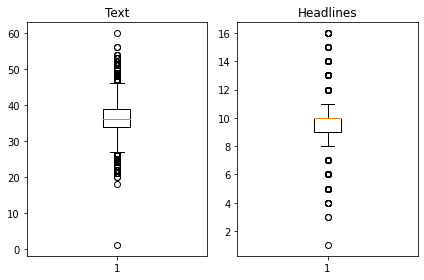

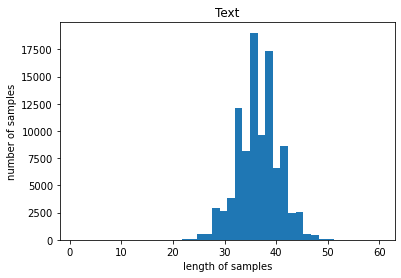

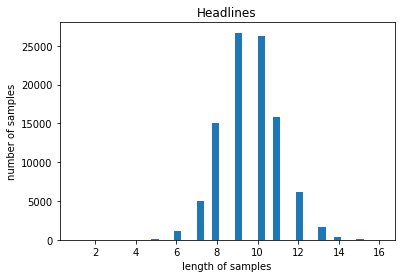

In [19]:
import matplotlib.pyplot as plt

text_len = [len(x.split()) for x in data['text']]
headlines_len = [len(x.split()) for x in data['headlines']]

print('텍스트 길이 최대: ', np.max(text_len))
print('텍스트 길이 최소: ', np.min(text_len))
print('텍스트 길이 평균: ', np.mean(text_len))
print('헤드라인 길이 최대: ', np.max(headlines_len))
print('헤드라인 길이 최소: ', np.min(headlines_len))
print('헤드라인 길이 평균: ', np.mean(headlines_len))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

text, headlines 길이를 임의로 정해줌

In [20]:
max_text_len = 60
max_headline_len = 16

최대 길이를 기준으로 나눴을때의 최대 길이보다 짧은 데이터의 비율

In [21]:
def below_threshold_len(max_len, list):
  count = 0
  for s in list:
    if len(s.split()) <= max_len:
      count += 1
  
  print(f'길이가 {max_len}보다 짧은 데이터의 비율: {count/len(list)}')


In [22]:
below_threshold_len(max_text_len, data['text'])
below_threshold_len(max_headline_len, data['headlines'])

길이가 60보다 짧은 데이터의 비율: 1.0
길이가 16보다 짧은 데이터의 비율: 1.0


길이가 max_len 보다 긴 데이터들을 삭제

In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= max_text_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= max_headline_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


시작 토큰과 마무리 토큰 추가해줌


In [24]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'starttoken ' + x)
data['decoder_output'] = data['headlines'].apply(lambda x : x + ' endtoken')


In [25]:
data.head()

,headlines,text,decoder_input,decoder_output
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iit pg program mach...,starttoken upgrad learner switches to career i...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,starttoken delhi techie wins free food from sw...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india 12 matc...,new zealand dfeated india wickets fourth odi h...,starttoken new zealand end rohit sharma led in...,new zealand end rohit sharma led india 12 matc...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,starttoken aegon life iterm insurance plan hel...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,starttoken have known hirani for yrs what if m...,have known hirani for yrs what if metoo claims...


데이터들 Numpy 타입으로 바꿔줌

In [26]:
encoder_input = np.array(data['text'])

decoder_input = np.array(data['decoder_input'])
decoder_output = np.array(data['decoder_output'])

- train, test 데이터셋 나눠주기

데이터들을 한 번 잘 섞어줌

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_output = decoder_output[indices]

섞였는지 확인

In [28]:
encoder_input[:5]

array(['trailer ranveer singh sara ali khan starer simmba rleased directed rohit shetty film orphan named simmba blieves corrupt officer life ideal life inspires become one also starring sonu sood ashutosh rana film scheduled rlease dcember 28',
       'oneplus anounced launch oneplus red edition priced 39 99 featuring 8gb ram 128gb built storage oneplus red edition dramatic take oneplus vailable sale 12 00 noon 16th july oneplus bullets wireless also go sale 12 00 noon 16th july',
       'us asked pakistan enact legislation formally bans 26 11 mumbai attack mastermind hafiz saeed led jmaat ud dawa falah insaniat foundation two longer banned ordinance banned lapsed pakistani government extend removal ban runs counter pakistan comitment fatf fight terorism us said',
       'islamic school teacher umar haque found guilty friday trying recruit army children carry wave isis inspired attacks across london made students roleplay attacking officers showed violent militant propganda haque blie

테스트 사이즈 설정(0.2)

In [29]:
val_size = int(encoder_input.shape[0] * 0.2)
val_size

19672

In [30]:
encoder_input_train = encoder_input[:-val_size]
decoder_input_train = decoder_input[:-val_size]
decoder_output_train = decoder_output[:-val_size]

encoder_input_test = encoder_input[-val_size:]
decoder_input_test = decoder_input[-val_size:]
decoder_output_test = decoder_output[-val_size:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


- train, test 나눠주는 함수로 정의하여 편하게 이용

In [31]:
def create_train_test(encoder_input, decoder_input, decoder_target):

  #input 사이즈와 같은 크기의 배열 생성 후 섞음
  indices = np.arange(encoder_input.shape[0])
  np.random.shuffle(indices)

  #정수 시퀀스를 이용해 데이터를 잘 섞어줌
  encoder_input = encoder_input[indices]
  decoder_input = decoder_input[indices]
  decoder_target = decoder_target[indices]

  #테스트 데이터 크기 정의
  val_size = int(len(encoder_input)*0.2)

  #데이터 val_size 기준으로 양분
  encoder_input_train = encoder_input[:-val_size]
  decoder_input_train = decoder_input[:-val_size]
  decoder_target_train = decoder_target[:-val_size]

  encoder_input_test = encoder_input[-val_size:]
  decoder_input_test = decoder_input[-val_size:]
  decoder_target_test = decoder_target[-val_size:]

  print('훈련 데이터의 개수 :', len(encoder_input_train))
  print('훈련 레이블의 개수 :', len(decoder_input_train))
  print('테스트 데이터의 개수 :', len(encoder_input_test))
  print('테스트 레이블의 개수 :', len(decoder_input_test))
  
  return encoder_input_train, decoder_input_train, decoder_target_train, encoder_input_test, decoder_input_test, decoder_target_test

- 정수 인코딩 진행

먼저 토크나이저 설정해줌

In [32]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

단어의 빈도수를 체크해봄

In [33]:
threshold = 4
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 71761
등장 빈도가 3번 이하인 희귀 단어의 수: 40914
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 30847
단어 집합에서 희귀 단어의 비율: 57.01425565418542
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1589212825750317


희귀 단어 등장 빈도가 4% 정도밖에 안되기 때문에 얘들은 훈련 데이터에서 빼준다.
단어장의 크기는 약 19000정도로 할 예정

In [34]:
src_vocab = 30847
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

정수 인코딩 시작

In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1804, 899, 49, 2235, 573, 74, 605, 6296, 187, 265, 891, 2222, 15, 20140, 230, 6296, 3299, 5296, 321, 145, 8933, 145, 13350, 208, 17, 6, 1535, 3588, 8361, 8934, 4424, 15, 432, 235, 361, 651], [2253, 97, 495, 2253, 878, 1252, 2432, 2169, 1874, 1641, 18141, 350, 23019, 855, 3565, 2253, 878, 1252, 11906, 106, 2253, 984, 680, 141, 26, 15869, 5297, 500, 2253, 5298, 3609, 6, 298, 680, 141, 26, 15869, 5297, 500], [5, 70, 44, 12968, 4861, 4547, 5932, 574, 189, 78, 223, 3589, 4170, 2815, 125, 6362, 6043, 12242, 17304, 17305, 1492, 12, 1869, 614, 5338, 614, 21455, 477, 8, 3883, 3438, 412, 307, 2403, 44, 3760, 23020, 730, 1123, 5, 1]]


headline에 대해서도 진행

In [36]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [37]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31818
등장 빈도가 3번 이하인 희귀 단어의 수: 18142
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13676
단어 집합에서 희귀 단어의 비율: 57.0180401030863
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2907131220957844


단어장 개수는 9824 정도로 하면 될 것 같다.

In [38]:
tar_vocab = 13676
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_output_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_output_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_output_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 595, 6, 375, 226, 1299, 766, 168, 3622, 318], [1, 1420, 1065, 3531, 1271, 3, 283, 7, 378, 4, 8, 7, 1670, 327], [1, 14, 139, 103, 3, 136, 2022, 1649, 11987, 11988], [1, 911, 1313, 3, 122, 166, 6, 616, 3, 142, 538], [1, 1498, 7, 397, 4428, 31, 213, 6094, 1404, 76]]
target
decoder  [[595, 6, 375, 226, 1299, 766, 168, 3622, 318, 2], [1420, 1065, 3531, 1271, 3, 283, 7, 378, 4, 8, 7, 1670, 327, 2], [14, 139, 103, 3, 136, 2022, 1649, 11987, 11988, 2], [911, 1313, 3, 122, 166, 6, 616, 3, 142, 538, 2], [1498, 7, 397, 4428, 31, 213, 6094, 1404, 76, 2]]


빈도수에 따른 전처리를 해줬는데 이렇게 되면 또 다시 null값이 발생할 수 있기때문에 확인해보고 데이터에서 지워준다.

In [39]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


- 패딩 진행해줌

In [40]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headline_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headline_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headline_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headline_len, padding='post')


## Step 3. 어텐션 메커니즘 사용하여 모델 설계 (추상적 요약)


- LSTM층 설계

In [41]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#인코더 설계 시작
embedding_dim = 256
hidden_size = 128

#인코더
encoder_inputs = Input(shape=(max_text_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5, recurrent_dropout = 0.5)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.5)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [42]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

In [43]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 256)      7896832     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 128),    197120      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

- 어텐션 레이어 추가

In [44]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 256)      7896832     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 128),    197120      ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

- 모델 훈련

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 39s 89ms/step - loss: 4.6524 - val_loss: 4.2679
Epoch 2/50
308/308 [==============================] - 27s 87ms/step - loss: 4.1732 - val_loss: 3.9734
Epoch 3/50
308/308 [==============================] - 28s 90ms/step - loss: 3.8895 - val_loss: 3.7576
Epoch 4/50
308/308 [==============================] - 28s 90ms/step - loss: 3.6974 - val_loss: 3.6263
Epoch 5/50
308/308 [==============================] - 28s 90ms/step - loss: 3.5630 - val_loss: 3.5484
Epoch 6/50
308/308 [==============================] - 28s 90ms/step - loss: 3.4522 - val_loss: 3.4597
Epoch 7/50
308/308 [==============================] - 28s 90ms/step - loss: 3.3589 - val_loss: 3.4016
Epoch 8/50
308/308 [==============================] - 28s 90ms/step - loss: 3.2766 - val_loss: 3.3396
Epoch 9/50
308/308 [==============================] - 28s 90ms/step - loss: 3.2054 - val_loss: 3.2953
Epoch 10/50
308/308 [==============================] - 28s 90ms/step - loss: 3.142

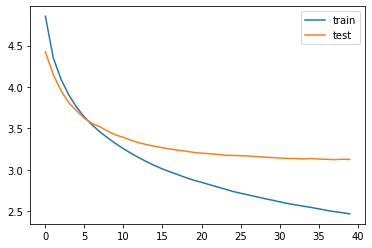

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 인퍼런스 모델 구현

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_headline_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


- 모델 테스트하기

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['starttoken']) and i!=tar_word_to_index['endtoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

In [51]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, max_text_len)))
    print("\n")

원문 : government vaults unclaimed deposits amounting 19 567 crore june 2018 33 higher previous year unclaimed deposits stood 14 crore deposits tansferred rbi education awareness fund takes bank accounts deposits operated claimed 10 years 
실제 요약 : 19 crore left unclaimed in bank as of june 2018 
예측 요약 :  deposits of money in deposits of crore in 2016 17


원문 : bahrain court tuesday revoked ctizenship 115 people awarded life sntences 53 others mass terorism trial prosecutors said accused detonated bombs rceived weapons training atempted kill police officers bahrain claimed iran helped accused set militant group called zulfiqar 
실제 요약 : bahrain revokes ctizenship of 115 people on teror charges 
예측 요약 :  isis claims responsbility for killing us in iraq


원문 : comedian turned actor andy dick fired two movies accused sexual misconduct harassment sets andy accused groping people non consensual kissing licking said anybody might kissed somebody cheek say good bye thing said funny 
실제 요약 : comed

## Step 5. Summa를 이용해 추출적 요약 해보기

In [52]:
import requests
from summa.summarizer import summarize

In [53]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [54]:
print(data[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

In [55]:
for i in range(5):
    print("* 원문 :", data['text'][i])
    print("* 실제 요약 :", data['headlines'][i])
    print("* 추출적 요약 :", summarize(data['text'][i], ratio=0.4))
    print("\n")


* 원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
* 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
* 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


* 원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
* 실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
* 추출적 요약 : Users get one CRED coin per rup

## 훈련 기록 및 회고


1차
----

- embedding_dim : 256
- hidden_size : 256
- dropout 0.5
- recurrent_dropout : x
- 결과 : Epoch 23/50
254/254 [==============================] - 17s 66ms/step - loss: 2.8334 - val_loss: 3.9281
Epoch 23: early stopping

2차
---

- embedding_dim : 128
- hidden_size : 128
- dropout : 0.5
- recurrent_dropout : 0.5
- 결과 : Epoch 44/50
254/254 [==============================] - 124s 487ms/step - loss: 3.1554 - val_loss: 3.9407
Epoch 44: early stopping

3차
---

- embedding_dim : 128
- hidden_size : 128
- dropout : 0.5
- recurrent_dropout : x
- 결과 : Epoch 50/50
308/308 [==============================] - 17s 57ms/step - loss: 2.2820 - val_loss: 2.8037

4차
---

- embedding_dim : 256
- hidden_size : 128
- dropout : 0.5
- recurrent_dropout : x
- 결과 : Epoch 37/50
308/308 [==============================] - 22s 71ms/step - loss: 2.4450 - val_loss: 3.0373
Epoch 37: early stopping

5차
---

- embedding_dim : 256
- hidden_size : 128
- recurrent_dropout : x
- 결과 : Epoch 44/50
308/308 [==============================] - 28s 90ms/step - loss: 2.2781 - val_loss: 2.9656
Epoch 44: early stopping
 실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
* 추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.

결과 비교
---
|  실제 요약  |추상적 요약(Abstractive)  |
|:-:|:-:|
|petrol price cut by 16 litre diesel by 10 litre   |petrol price cut by diesel by diesel by diesel by end   |
|New Zealand end Rohit Sharma-led India's 12-match winning streak   |The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.   |
|betles picasso art given in bllionaire will   |michael jackson dies after being paid for lakh at her age   |

|  실제 요약  |추출적 요약(Extractive)  |
|:-:|:-:|
|upGrad learner switches to career in ML & Al with 90% salary hike   |upGrad's Online Power Learning has powered 3 lakh+ careers. |

추상적 요약은 실제 요약과는 다르지만 어느정도 원문 내용을 정리하는 새로운 요약을 만들어주려고 하는 것 같은데 모델 성능이 안좋아서 그런지 말도 안되는 번역이 나오기도 함  
추출적 요약은 어느정도 비슷해 보이긴 하지만 문장이 너무 길어서 아쉬움

회고
---
데이터를 확인할 때 문장에 'iiit'가 들어있는 걸 보고 한 단어에서 같은 알파벳이 3개이상 연속으로 나오는 단어들을 최대 2개까지 나오게 만들어주는 과정을 추가했음
그리고 실제 요약중에 숫자들이 들어가는 요약도 있어서 숫자를 제외하는 부분에서 숫자도 포함하게 만들어 줬음
    # 단어 내에 같은 문자들이 3개 이상 연속해서 반복되면 삭제하고 최대 2개까지만 반복되도록 만들어줌( ex. iiit -> iit )
    b=[]
    for i in sentence.split():
      a = list(i)
      char_cnt = 0
      for j in a:
        if a.count(j) >= 3:
          a.remove(j)
      word_a = ''.join(a)
      b.append(word_a)
    sentence = ' '.join(b)

하지만 이런 과정을 추가해도 눈에 띄는 성과를 얻지 못했음. 다른 전처리 방법을 택했어야 하는건지 모델을 다양하게 써봐야 하는건지를 잘 모르겠음...

